# Read and view Delft3D grid, depth and enclosure files

* Move reading functionality to JulesD3D

In [26]:
%matplotlib widget

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
from JulesD3D.dep import Depth
from JulesD3D.grid import Grid
from JulesD3D.enc import Enclosure
from JulesD3D.bnd import Boundaries
from os import path, walk
from cmocean.cm import deep
colormap = deep
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
%reload_ext autoreload

## Load grid + depth + boundaries

In [29]:
folder_name = "/Users/julesblom/Dropbox/TU/Master/Thesis/Runs/Current/ResetEvery5_Slope1.25/Run01"

In [30]:
if not path.exists(folder_name):
    raise Exception('Looks like read folder does not exist, aborting')
    
basename = path.basename(folder_name)
plot_title, _ = path.splitext(basename)
title = basename

In [31]:
all_filenames = []

# Find filenames in template/read folder
for root, dirs, files in walk(folder_name):
    for file in files:
        if file.endswith('bnd'):
            bnd_filename = path.join(folder_name, file)
            all_filenames.append({"type": "Boundary", "filename": path.split(bnd_filename)[1]})
        elif file.endswith('dep'):
            dep_filename =  path.join(folder_name, file)
            all_filenames.append({"type": "Depth", "filename": path.split(dep_filename)[1]})
        elif file.endswith('enc'):
            enc_filename =  path.join(folder_name, file)
            all_filenames.append({"type": "Enclosure", "filename":path.split(enc_filename)[1]})
        elif file.endswith('grd'):
            grid_filename = path.join(folder_name, file)
            all_filenames.append({"type": "Grid", "filename":path.split(grid_filename)[1]})        

In [32]:
if not all_filenames:
    raise Exception('Could not find any Delft3D files in provided folder')

In [33]:
files_df = pd.DataFrame(data=all_filenames)
files_df

,type,filename
0,Depth,gen_36_by_26km.dep
1,Boundary,QChannelZdeep.bnd
2,Grid,36km_26km_W60Channel.grd
3,Enclosure,36km_1cellchannel_15km.enc


In [34]:
grid = Grid.read(grid_filename)
grid.shape

(181, 131)

In [35]:
dep = Depth.read(dep_filename, grid.shape)
depth = dep.values[0:-1,0:-1]

In [36]:
enc = Enclosure.read(enc_filename)

Enclosure values


,x,y
0,1,75
1,64,75
2,64,1
3,69,1
4,69,75
5,132,75
6,132,182
7,1,182
8,1,75


In [37]:
enclosure_x, enclosure_y = enc.getXY()

In [38]:
bnd = Boundaries.read(bnd_filename)

Boundary file


,name,type,forcing,m1,n1,m2,n2,reflection coefficient,vertical profile,label1,label2
0,Discharge,Q,T,66,1,66,1,200.0,3d-profile,NaN,NaN
1,deep,Z,T,2,182,131,182,200.0,NaN,NaN,NaN


In [39]:
bnd.getXY()

([(66, 66), (2, 131)], [(1, 1), (182, 182)])

## Map plot

In [40]:
# x_gridcells, y_gridcells = grid.x.shape

In [41]:
# almost!
# xGridstep, yGridstep = [int((grid.x[-1][-1] / grid.y.shape[1])+1), int((grid.y[-1][-1] / grid.y.shape[0])+1)]
# print(xGridstep, yGridstep)

In [42]:
x_gridstep = 200
y_gridstep = 200

In [81]:
# fig_length, fig_width = [x_gridcells/10, y_gridcells/10]
min_depth, max_depth = [np.amin(depth), np.max(depth)]

In [44]:
# Minus 1 cause off by 1, -3 because that looks nice in the plot (shhh)
plot_enclosure_x_coords = [i - 1 for i in enclosure_x] # oo GIFs afac
plot_enclosure_y_coords = [i - 3 for i in enclosure_y]

In [45]:
plot_enclosure_x_meters = [i * x_gridstep for i in plot_enclosure_x_coords]
plot_enclosure_y_meters = [i * y_gridstep for i in enclosure_y]

In [20]:
bc_x_coords, bc_y_coords = bnd.getXY()

In [21]:
bc_x_meters = [(i[0] * x_gridstep, i[1] * y_gridstep) for i in bc_x_coords]
bc_y_meters = [(i[0] * x_gridstep, i[1] * y_gridstep) for i in bc_y_coords]

In [22]:
deep_1 = (bc_x_meters[1][0], bc_y_meters[1][0])
deep_2 = (bc_x_meters[1][1], bc_y_meters[1][1])
deep_bc_meters = (deep_1, deep_2)
deep_bc_meters

((400, 36400), (26200, 36400))

In [23]:
discharge_location_x = bc_x_meters[0][0]
discharge_location_y = bc_y_meters[0][0]
(discharge_location_x, discharge_location_y)

(13200, 200)

In [24]:
x_grid = grid.x.data[0]
y_grid = grid.y.data[:,1]

In [46]:
fig, [gridAx0, gridAx1] = plt.subplots(1,2, figsize=(10, 5))

fig.suptitle(title, fontsize=13)
# In M by N numbers
gridAx0.set_title('In grid numbers')
gridAx0.set_aspect('equal')
gridAx0.plot(plot_enclosure_x_coords, plot_enclosure_y_coords, c='#ffb9be', linewidth=3)
gridAx0.pcolor(depth, vmin=min_depth, vmax=max_depth, cmap=colormap) 
gridAx0.set_xlabel('m')
gridAx0.set_ylabel('n')
# gridAx0.set_xticks(coords_x_ticks)
# gridAx0.set_xticklabels(labels=coords_x_ticks, rotation='vertical')
gridAx0.grid(linewidth=0.5, alpha=0.8, color='w')# xdata=newGrid.x[0][1:-1], ydata=newGrid.y[0][1:-1])
gridAx0.scatter(bc_x_coords, bc_y_coords, c='black', linewidth=3)

# In meters

gridAx1.set_title('In meters')
gridAx1.set_aspect('equal')
gridAx1.plot(plot_enclosure_x_meters, plot_enclosure_y_meters, c='#ffb9be', linewidth=1.5)
grid_im = gridAx1.pcolor(grid.x, grid.y, depth[0:-1,0:-1], vmin=min_depth, vmax=max_depth, cmap=deep)
gridAx1.set_ylabel('Length $n$ [m]', fontsize=10)
gridAx1.set_ylabel('Length $n$ [m]', fontsize=10)
gridAx1.set_xlim((0, 26200))
gridAx1.set_ylim(0, 36700)
gridAx1.set_xticks(x_grid, minor=True)
gridAx1.set_yticks(y_grid, minor=True)

gridAx1.grid(whicr='minor', alpha=0.15)
gridAx1.grid(which='major', alpha=0.75)

discharge_point = gridAx1.scatter(discharge_location_x, discharge_location_y, c='black', marker="^", label="Discharge", linewidths=7, edgecolors="white")
cbar1 = fig.colorbar(grid_im, ax=gridAx1)
cbar1.ax.set_ylabel("Depth [m]", rotation=-90, va="bottom", fontsize=16)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Report plot

In [29]:
bc_x_meters[1:][0], bc_y_meters[1:][0]

((400, 26200), (36400, 36400))

In [47]:
fig_r, ax_r = plt.subplots(nrows=1, figsize=(7, 8))

# axins = zoomed_inset_axes(ax_r, 2.5, loc=2) # zoom-factor: 2.5, location: upper-left

ax_r.set_title('Map view of model domain', fontsize=16)
ax_r.set_aspect('equal')
ax_r.plot(bc_x_meters[1:][0], bc_y_meters[1:][0], c='coral', linewidth=7.5) #label='Zero discharge BC',
text_zero_discharge = ax_r.text(8000, 35200, "Zero discharge B.C.", color="white", fontsize=13)
text_zero_discharge.set_path_effects([PathEffects.withStroke(linewidth=0.8, foreground='black')])

ax_r.plot(plot_enclosure_x_meters, plot_enclosure_y_meters, c='white', linewidth=2.5, label="Enclosure")
grid_im = ax_r.pcolor(grid.x, grid.y, depth[0:-1,0:-1], vmin=min_depth, vmax=max_depth, cmap=deep)
ax_r.set_xlabel('Width $m$ [m]', fontsize=16)
ax_r.set_ylabel('Length $n$ [m]', fontsize=16)
ax_r.set_xlim(0, 26200)
ax_r.set_ylim(0, 36700)

# grid
ax_r.set_xticks(x_grid, minor=True)
ax_r.set_yticks(y_grid, minor=True)

ax_r.grid(which='minor', alpha=0.15)
ax_r.grid(which='major', alpha=0.75)

discharge = ax_r.scatter(discharge_location_x - 100, discharge_location_y + 400, s=[175], c='coral', marker="^", edgecolors="white") # label="Discharge BC",
text_discharge = ax_r.text(discharge_location_x - 20, discharge_location_y + 450, "Discharge B.C.", fontsize=13)
text_discharge.set_path_effects([PathEffects.withStroke(linewidth=1.5, foreground='w')])

# colorbar
cbar = fig_r.colorbar(grid_im, ax=ax_r)
cbar.ax.set_ylabel("Depth [m]", rotation=-90, va="bottom", fontsize=16)

# legend 
fig_r.legend(loc=(0.134,.383), borderpad=0.5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Movement of cumulative thickest deposits

In [55]:
# I need to add the times and thickness as labels
thickest_125 = [
    [14900, 18200],
    [11300, 18400],
    [11300, 18400],
    [11500, 18600],
    [11500, 18600],
    [11500, 18600],
    [11500, 18600],
    [12900, 21600],
    [12900, 21600],
    [12900, 21600]
]

In [65]:
thick_125_x, thick_125_y = zip(*thickest_125)

In [79]:
labels_125 = [f"Run {i+1*5}: x m" for i in range(len(thickest_125))]
labels_125

['Run 5: x m',
 'Run 6: x m',
 'Run 7: x m',
 'Run 8: x m',
 'Run 9: x m',
 'Run 10: x m',
 'Run 11: x m',
 'Run 12: x m',
 'Run 13: x m',
 'Run 14: x m']

In [80]:
fig_r, ax_r = plt.subplots(nrows=1, figsize=(7, 8))

# axins = zoomed_inset_axes(ax_r, 2.5, loc=2) # zoom-factor: 2.5, location: upper-left

ax_r.set_title('Map view of model domain', fontsize=16)
ax_r.set_aspect('equal')

grid_im = ax_r.pcolor(grid.x, grid.y, depth[0:-1,0:-1], vmin=min_depth, vmax=max_depth, cmap=deep)
ax_r.set_xlabel('Width $m$ [m]', fontsize=16)
ax_r.set_ylabel('Length $n$ [m]', fontsize=16)
ax_r.set_xlim(0, 26200)
ax_r.set_ylim(0, 35700)

ax_r.scatter(thick_125_x, thick_125_y, label=labels_125)
for i, txt in enumerate(labels_125):
    ax_r.annotate(txt, (thick_125_x[i], thick_125_y[i]), c='white')

ax_r.set_xticks(x_grid, minor=True)
ax_r.set_yticks(y_grid, minor=True)

ax_r.grid(which='minor', alpha=0.15)
ax_r.grid(which='major', alpha=0.75)

# colorbar
cbar = fig_r.colorbar(grid_im, ax=ax_r)
cbar.ax.set_ylabel("Depth [m]", rotation=-90, va="bottom", fontsize=16)

# legend 
# fig_r.legend(loc=(0.134,.383), borderpad=0.5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'Depth [m]')

## 3D depth

In [ ]:
plt.close("all")

In [ ]:
fig_3d = plt.figure(figsize=(15,10))
ax_3d = fig_3d.gca(projection='3d')

print(depth.shape)
print(grid.x.shape)

surface = ax_3d.plot_surface(grid.x, grid.y, depth, cmap=colormap, label='Initial Bathymetry')
fig_3d.colorbar(surface, shrink=0.5, aspect=5, label='Depth [m]')

ax_3d.set_title("3D depth " + title, fontsize=13)
ax_3d.set_xlabel('X [m]')
ax_3d.set_ylabel('Y [m]')
ax_3d.set_zlabel('Depth [m]')
ax_3d.view_init(45, 70)

ax_3d.set_zlim(max_depth, min_depth)

# PyVista 3D Depth Widget

In [40]:
import pyvista as pv
from cmocean.cm import deep_r
pv.set_plot_theme("document") # for white background

In [35]:
grid.x[:-1,:-1].shape

(180, 130)

In [56]:
sargs = dict(
    height=0.25,
    vertical=True,
    position_x=0.05,
    position_y=0.25,
    title_font_size=20,
    label_font_size=17,
    shadow=True,
    n_labels=5,
    fmt="%.1f",
    font_family="arial",
)

cpos = [(65725.76592617724, 85328.65878007631, 593.0012198113377),
 (12900.0, 18000.0, -424.60451),
 (-0.1974308832715668, -0.20714561420700275, 0.9581814759456648)]

In [36]:
plot_x_mesh = grid.x[:-1,:-1]
plot_y_mesh = grid.y[:-1,:-1]
plot_z_mesh = -depth[:-1,:-1]

bottom_surface = pv.StructuredGrid(plot_x_mesh, plot_y_mesh, plot_z_mesh)
bottom_surface.field_arrays['depth'] = -depth[:-1,:-1].T
bottom_surface

StructuredGrid (0x1284d1e50)
  N Cells:	23091
  N Points:	23400
  X Bounds:	0.000e+00, 2.580e+04
  Y Bounds:	1.000e+02, 3.590e+04
  Z Bounds:	-6.992e+02, -1.500e+02
  Dimensions:	180, 130, 1
  N Arrays:	1

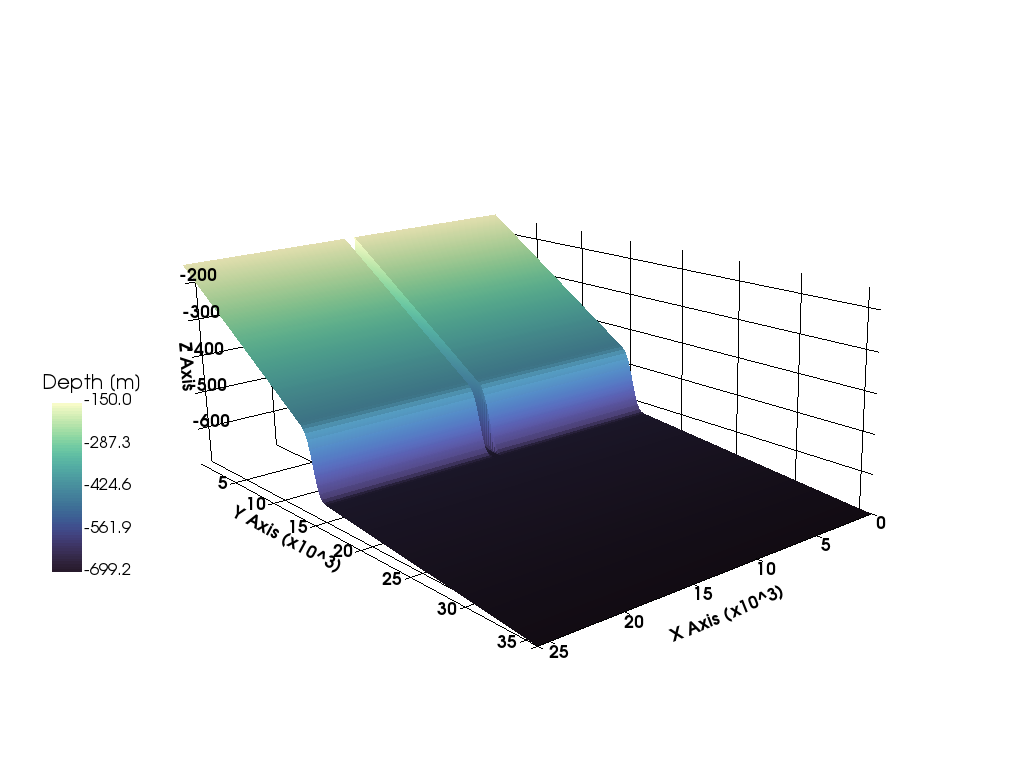

In [57]:
p = pv.Plotter(notebook=True)
p.add_mesh(bottom_surface, cmap=deep_r, stitle='Depth [m]', scalars='depth', scalar_bar_args=sargs, ambient=0.3)
p.show_grid()
p.set_scale(zscale=25)
p.show(screenshot="output_material/rememberbathymetry.png", cpos=cpos)

## Plot grid only

In [ ]:
# Flipped y and x for nice plot!
gridFig, gridAx = plt.subplots(figsize=(20, 10))
gridAx.plot(grid.y.transpose(), grid.x.transpose(), 'gray')
gridAx.plot(grid.y, grid.x, 'gray')
gridAx.set_xlabel('n [m]')
gridAx.set_ylabel('m [m]')
gridAx.set_aspect('equal')

In [ ]:
plt.close('all')